In [2]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/Coding/julia/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


In [96]:
dd = IMAS.json2imas("/Users/meneghini/.julia/dev/FUSE/sample/CAT_eq_ods.json");
plot(dd.equilibrium.time_slice[1])
IMAS.flux_surfaces(dd.equilibrium);

In [94]:
ϵ = 0.32
κ = 1.7
δ = 0.3
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 3.0
x_point=false
symmetric=true

resolution = 129

dd=IMAS.dd()
eq0=dd.equilibrium
FUSE.init(eq0, 0.0; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=x_point)

eqactor = FUSE.SolovevEquilibriumActor(eq0, 0.0, alpha=1, qstar=1.5,symmetric=symmetric)
@time FUSE.step(eqactor)
dd.equilibrium = FUSE.finalize(eqactor, resolution, (R0*(1-ϵ*1.7), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2))

eqt = dd.equilibrium.time_slice[1];
#println(eqt.profiles_1d.psi[1]," ",eqt.profiles_1d.psi[end])
#println(eqt.global_quantities.psi_axis," ", eqt.global_quantities.psi_boundary)
#contour(eqt.profiles_2d[1].psi,levels=[eqt.global_quantities.psi_axis/2,0.0])
#plot(eqt)

  0.740468 seconds (7.59 M allocations: 425.520 MiB, 27.00% gc time)


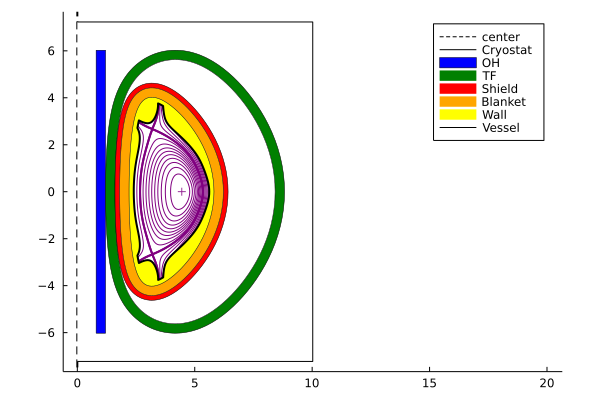

In [97]:
rb=IMAS.radial_build()
eqt=dd.equilibrium.time_slice[1]
plot(eqt,color=:gray)
FUSE.init(rb,eqt,is_nuclear_facility=true,δψ=0.1);
plot(eqt,color=:purple)
plot!(rb,outline=true)

In [91]:
rb;

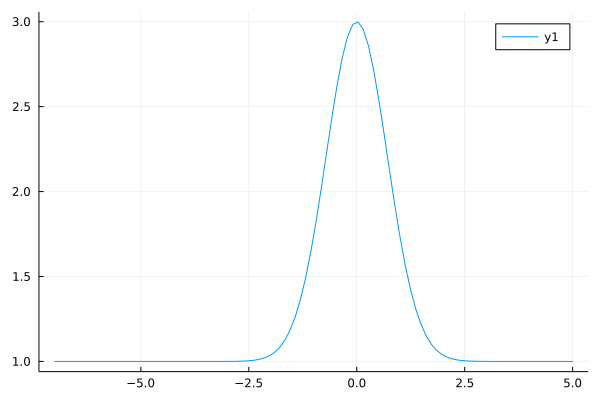

In [138]:
pz=range(-7,5,length=100)
scale=3
fact=exp.(-pz.^2)*(scale-1).+1
plot(pz,fact)